In [8]:
# from history_data import HistoryData
import pandas as pd
import requests
import datetime



# 0. Prepare Dataset

## Obtaining Data

### Getting Most Recent Data

In [9]:
class BybitHistoryData:
    symbol = None
    interval = None
    end_time = None
    klines = None
    limit = 1000
    start_time = None

    def __init__(self,category,symbol, interval, cicles = 3):
        self.category = category
        self.symbol = symbol
        self.interval = interval

        self.klines = self.get_bybit_klines(category,self.symbol, self.interval, self.end_time, self.limit)
        self.klines = self.klines['result']['list']
        self.klines.reverse()

        for i in range(cicles - 1):
            new_kline = self.get_bybit_klines(category,self.symbol, self.interval,self.get_current_oldest_time_minus_one(), self.limit)
            new_kline = new_kline['result']['list']
            new_kline.reverse()
            self.klines = new_kline + self.klines


    def get_current_oldest_time_minus_one(self):
        datetime_obj_one = datetime.datetime.fromtimestamp(
            int(self.klines[0][0]) / 1000)
        # print("[0]",str(datetime_obj_one))
        datetime_obj_two = datetime.datetime.fromtimestamp(
            int(self.klines[1][0]) / 1000)
        # print("[1]",str(datetime_obj_two))
        return self.subtract_datetime_difference(datetime_obj_one, datetime_obj_two)

    def subtract_datetime_difference(_, datetime1, datetime2):
        # Calculate the date difference
        date_difference = (datetime2.date() - datetime1.date()).days

        # Calculate the time difference
        time_difference = datetime2 - datetime1
        if datetime1 > datetime2:
            time_difference = datetime.timedelta(
                days=0, seconds=time_difference.seconds)

        # Subtract the date and time differences
        result = datetime1 - \
            datetime.timedelta(days=date_difference) - time_difference
        
        

        return int(result.timestamp() * 1000)

    @staticmethod
    def get_bybit_klines(category,symbol, interval, end_time, limit):
        base_url = 'https://api.bybit.com'
        endpoint = '/v5/market/kline'

        params = {
            'category': category,
            'symbol': symbol,
            'interval': interval,
            'limit': limit
        }

        # if start_time is not None:
        #     params['startTime'] = start_time

        if end_time is not None:
            params['endTime'] = end_time

        response = requests.get(base_url + endpoint, params=params)
        data = response.json()
        # print(data)
        return data

In [10]:
data = BybitHistoryData('linear',symbol="BTCUSDT", interval="5", cicles= 3 )
df = pd.DataFrame(data.klines, columns=["open_time", "open_price", "high_price", "low_price", "close_price", "volume", "turnover"])

In [11]:
print(len(df))

3000


### Save Data

In [12]:
file_path = '..\\Data\\df_most_recent.csv'
df.to_csv(file_path, index=False)

### Load Data and Drop Unnecessary Columns:

In [13]:
df = pd.read_csv(file_path)
print(df.head(5))

       open_time  open_price  high_price  low_price  close_price   volume  \
0  1713587100000     63845.9     63933.3    63831.7      63921.3  140.680   
1  1713587400000     63921.3     63939.5    63836.3      63932.1  312.187   
2  1713587700000     63932.1     64127.9    63932.0      64100.1  516.926   
3  1713588000000     64100.1     64206.8    64060.0      64159.1  448.984   
4  1713588300000     64159.1     64257.3    64129.1      64175.1  538.741   

       turnover  
0  8.986484e+06  
1  1.994644e+07  
2  3.310749e+07  
3  2.879849e+07  
4  3.458664e+07  


c:\Users\User\OneDrive - Robert Gordon University\Documents\GitHub\Honours-Project\env\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


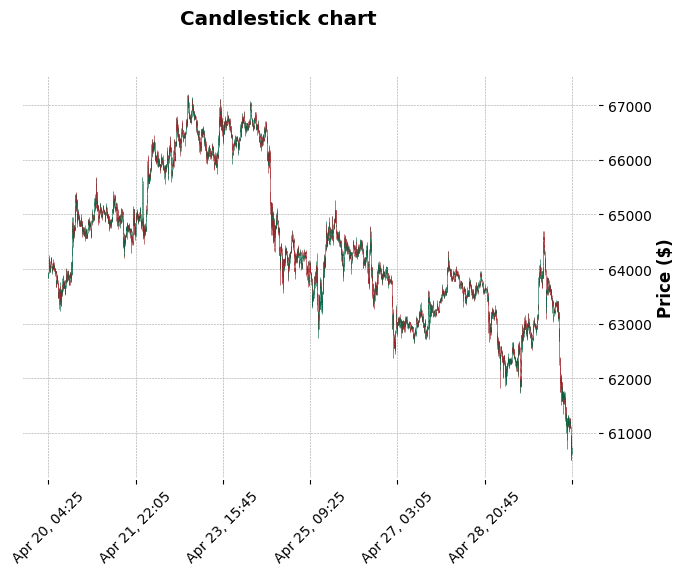

In [14]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import random
import pandas as pd
# Load data
test = df.copy()

# Convert timestamp (assuming milliseconds since the epoch)
test['open_time'] = pd.to_datetime(test['open_time'], unit='ms')

# Rename columns to conform to mplfinance requirements
test.rename(columns={'open_price': 'Open', 'high_price': 'High', 'low_price': 'Low', 'close_price': 'Close', 'volume': 'Volume'}, inplace=True)

# Set the date as the index
test.set_index('open_time', inplace=True)

# Ensure data is in the correct order
test.sort_index(inplace=True)

# Temporarily remove the 'volume' parameter to test the rest of the plot
mpf.plot(test[['Open', 'High', 'Low', 'Close']],
         type='candle',
         style='charles',
         title='Candlestick chart',
         ylabel='Price ($)')
